In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import harmonypy as hm

from scSLAT.model import spatial_match
from scSLAT.metrics import region_statistics
from scSLAT.viz import match_3D_multi, match_3D_celltype, hist

In [5]:
rna = sc.read_h5ad('../glue_rna-E11_20um.h5ad')
atac = sc.read_h5ad('../glue_atac-E11_20um.h5ad')

In [6]:
atac.obsm['spatial_bak'] = atac.obsm['spatial'].copy()
atac.obsm['spatial'] = np.array([atac.obsm['spatial_bak'][:,0],-atac.obsm['spatial_bak'][:,1]]).T

In [7]:
embd0 = rna.obsm['X_glue']
embd1 = atac.obsm['X_glue']

In [17]:
# make a dataframe, colname is 'batch', colvalue is 'rna' or 'atac' according to the embd0 and embd1
meta = pd.DataFrame({'batch':['rna']*embd0.shape[0]+['atac']*embd1.shape[0]})

In [18]:
harm = hm.run_harmony(np.concatenate([embd0, embd1]), meta, 'batch', max_iter_harmony=20)
Z = harm.Z_corr.T

2023-02-01 15:59:56,924 - harmonypy - INFO - Iteration 1 of 20
2023-02-01 15:59:58,761 - harmonypy - INFO - Iteration 2 of 20
2023-02-01 16:00:00,391 - harmonypy - INFO - Iteration 3 of 20
2023-02-01 16:00:02,008 - harmonypy - INFO - Iteration 4 of 20
2023-02-01 16:00:03,611 - harmonypy - INFO - Iteration 5 of 20
2023-02-01 16:00:05,228 - harmonypy - INFO - Iteration 6 of 20
2023-02-01 16:00:06,348 - harmonypy - INFO - Iteration 7 of 20
2023-02-01 16:00:06,890 - harmonypy - INFO - Iteration 8 of 20
2023-02-01 16:00:07,459 - harmonypy - INFO - Converged after 8 iterations


In [19]:
embd0 = Z[:rna.shape[0],:]
embd1 = Z[rna.shape[0]:,:]

In [20]:
best, index, distance = spatial_match([embd0, embd1])

In [21]:
rna_df = pd.DataFrame({'index':range(embd0.shape[0]),
                          'x': rna.obsm['spatial'][:,0],
                          'y': rna.obsm['spatial'][:,1],
                          'leiden':rna.obs['annotation']})

atac_df = pd.DataFrame({'index':range(embd1.shape[0]),
                          'x': atac.obsm['spatial'][:,0],
                          'y': atac.obsm['spatial'][:,1],
                          'leiden':atac.obs['Clusters']})

matching = np.array([range(best.shape[0]), best])
region_statistics(distance[:,0])

0.500~0.550         0          0.000%
0.550~0.600         0          0.000%
0.600~0.650         0          0.000%
0.650~0.700         0          0.000%
0.700~0.750         0          0.000%
0.750~0.800         4          0.191%
0.800~0.850        88          4.192%
0.850~0.900       603         28.728%
0.900~0.950      1131         53.883%
0.950~1.000       273         13.006%


/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:204: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 9 cell types; dataset2: 7 cell types; 
                    Total :16 celltypes; Overlap: 0 cell types 
                    Not overlap :[['Heart', 'Liver', 'Brain', 'Mesenchyme', 'Lung primordium', 'Head mesenchyme', 'Surface ectoderm', 'Spinal cord', 'Connective tissue', 'C1', 'C5', 'C6', 'C7', 'C2', 'C4', 'C3']]
Subsample 300 cell pairs from 2099


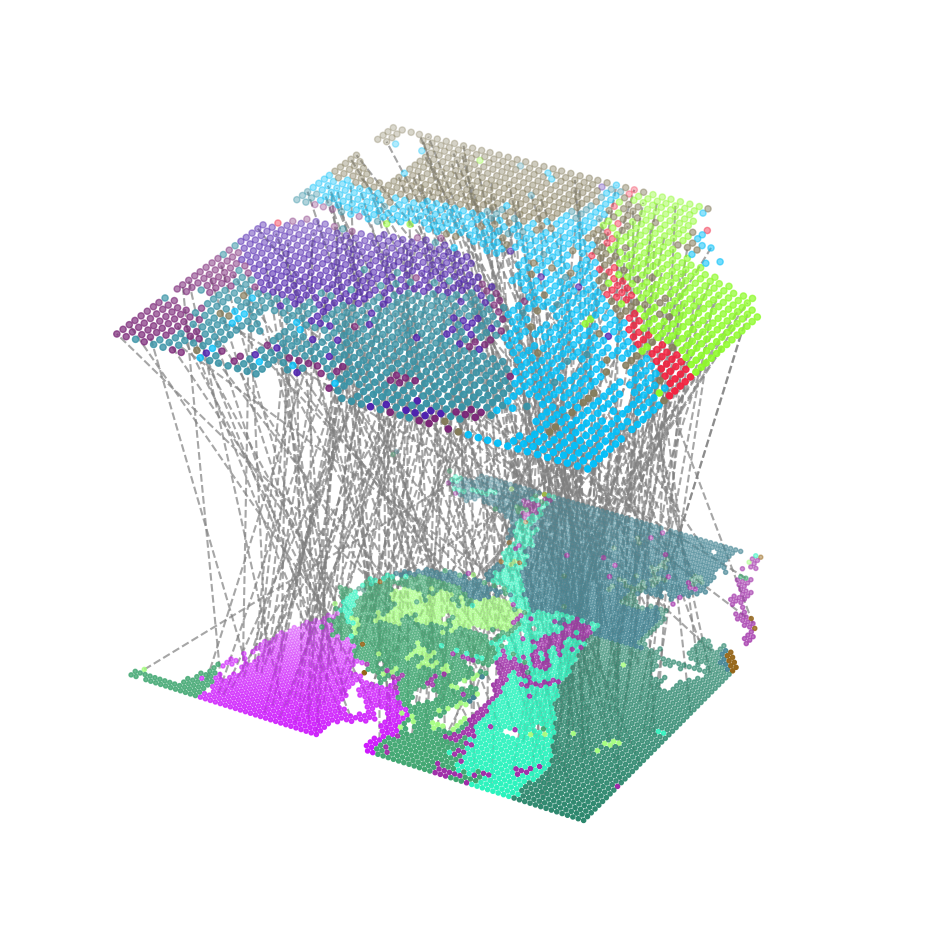

In [22]:
# %matplotlib inline
matching_filter = matching[:, distance[:,0] > 0.9]
multi_align = match_3D_multi(rna_df, atac_df, matching, meta='leiden', rotate=['y','y'],
                             scale_coordinate=True,subsample_size=300)

multi_align.draw_3D([12, 12], line_width =1.5, point_size=[9,20], hide_axis=True, 
                    show_error=False)

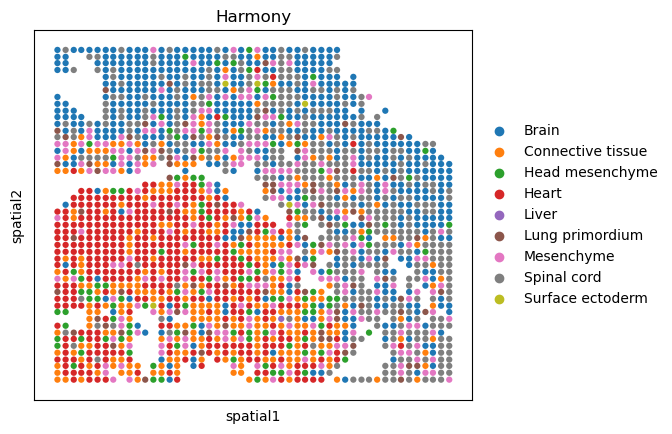

In [23]:
atac.obs['target_celltype'] = rna_df.iloc[matching[1,:],:]['leiden'].to_list()
atac.obs.target_celltype.value_counts()
sc.pl.spatial(atac, spot_size=10, color='target_celltype', frameon=True, title='Harmony')